# Dirac IRF Fisher Information Analysis

## Introduction

This notebook implements Fisher information analysis for fluorescence lifetime imaging microscopy (FLIM) with an ideal Dirac delta instrument response function (IRF). The analysis reproduces the seminal work of KÃ¶llner and Wolfrum (1992) on determining the fundamental precision limits of lifetime measurements.

### Fisher Information Theory

Fisher information quantifies the amount of information that an observable random variable carries about an unknown parameter. In the context of FLIM, it provides a theoretical lower bound on the precision of lifetime measurements through the **CramÃ©r-Rao bound**:

$$\text{Var}(\hat{\tau}) \geq \frac{1}{F(\tau)}$$

where:
- $\text{Var}(\hat{\tau})$ is the variance of any unbiased estimator of the lifetime $\tau$
- $F(\tau)$ is the Fisher information

For photon counting measurements with Poisson statistics, the Fisher information is:

$$F(\tau) = \sum_{i=1}^{n} \frac{1}{\mu_i} \left(\frac{\partial \mu_i}{\partial \tau}\right)^2$$

where $\mu_i$ is the expected number of photons in time bin $i$.

### The Dirac IRF Case

The Dirac delta IRF represents an ideal instrument with infinitely fast response:

$$\text{IRF}(t) = \delta(t)$$

In this case, the measured fluorescence decay is simply:

$$I(t) = A \exp(-t/\tau)$$

with periodic boundary conditions due to pulsed excitation at repetition period $T$.

### Key Parameters

- **$\tau$**: Fluorescence lifetime (ns) - the characteristic decay time of the fluorophore
- **$T$**: Laser repetition period (ns) - time between excitation pulses
- **$n$**: Number of time bins - temporal resolution of the measurement
- **$N$**: Total photon count - determines signal-to-noise ratio

### F-value Definition

Following KÃ¶llner and Wolfrum, we define the F-value as a normalized precision measure:

$$F = \frac{\sigma_\tau}{\tau} \sqrt{N}$$

where $\sigma_\tau$ is the standard deviation of lifetime estimates. This metric is independent of photon count and allows comparison across different experimental conditions.

### Literature References

1. **KÃ¶llner, M., & Wolfrum, J. (1992).** "How many photons are necessary for fluorescence-lifetime measurements?" *Chemical Physics Letters*, 200(1-2), 199-204.
   - Seminal paper establishing Fisher information analysis for FLIM
   - Provides analytical solutions for the Dirac IRF case

2. **Lakowicz, J. R. (2006).** *Principles of Fluorescence Spectroscopy* (3rd ed.). Springer.
   - Comprehensive reference on fluorescence lifetime measurements
   - Chapter 4 covers time-domain lifetime measurements

3. **Gerritsen, H. C., et al. (2002).** "Fluorescence lifetime imaging in scanning microscopy." *Handbook of Biological Confocal Microscopy*, 516-534.
   - Practical aspects of FLIM implementation
   - Discussion of IRF effects on measurements

### Objectives

This notebook will:
1. Implement Fisher information calculations for the Dirac IRF case
2. Validate results against KÃ¶llner-Wolfrum analytical solutions
3. Explore parameter space (lifetime, time bins) systematically
4. Visualize precision limits as a function of experimental parameters
5. Provide practical guidance for experimental design

## Setup and Imports

In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# Import our analysis modules
import sys
sys.path.insert(0, '../src')

from fisher_information import (
    dirac_irf_analysis,
    kollner_wolfrum_reference,
    calculate_f_value,
    validate_against_kollner_wolfrum
)
from visualization import (
    plot_fisher_analysis,
    setup_plot_style,
    export_figure,
    add_parameter_box
)
from core import AnalysisParameters

# Configure matplotlib for high-quality plots
setup_plot_style()
%matplotlib inline

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

print("Imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Imports successful!
NumPy version: 2.3.4
Matplotlib version: 3.10.7


## Parameter Definition

We define the experimental parameters for our Fisher information analysis. These parameters are chosen to match typical FLIM experimental conditions and to reproduce the KÃ¶llner-Wolfrum results.

### Physical Parameters

- **Repetition Period (T)**: 25 ns - typical for Ti:Sapphire lasers at 40 MHz repetition rate
- **Photon Count (N)**: 75,000 photons - representative of single-pixel FLIM measurements

### Parameter Ranges

- **Lifetimes (Ï„)**: 0.2 to 14.6 ns in 0.4 ns steps
  - Covers typical biological fluorophore lifetimes (1-4 ns)
  - Extends to longer lifetimes for comprehensive analysis
  
- **Time Bins (n)**: Powers of 2 from 4 to 1024
  - 4, 8, 16, 32, 64, 128, 256, 512, 1024 bins
  - Represents practical TCSPC (Time-Correlated Single Photon Counting) resolutions
  - Logarithmic spacing reveals scaling behavior

In [2]:
# Define experimental parameters
T = 25.0  # Repetition period in nanoseconds
num_photons = 75000  # Total photon count

# Define parameter ranges for systematic exploration
tau_range = np.arange(0.2, 15.0, 0.4)  # Lifetime range: 0.2 to 14.6 ns
time_bins_range = 2 ** (np.arange(9) + 2)  # Time bins: 4, 8, 16, ..., 1024

# Display parameter summary
print("=== Analysis Parameters ===")
print(f"Repetition Period (T): {T} ns")
print(f"Total Photon Count (N): {num_photons:,}")
print(f"\nLifetime Range:")
print(f"  Min: {tau_range[0]:.1f} ns")
print(f"  Max: {tau_range[-1]:.1f} ns")
print(f"  Steps: {len(tau_range)}")
print(f"\nTime Bins Range:")
print(f"  Values: {time_bins_range.tolist()}")
print(f"  Min: {time_bins_range[0]} bins")
print(f"  Max: {time_bins_range[-1]} bins")
print(f"\nTotal calculations: {len(tau_range) * len(time_bins_range):,}")

=== Analysis Parameters ===
Repetition Period (T): 25.0 ns
Total Photon Count (N): 75,000

Lifetime Range:
  Min: 0.2 ns
  Max: 14.6 ns
  Steps: 37

Time Bins Range:
  Values: [4, 8, 16, 32, 64, 128, 256, 512, 1024]
  Min: 4 bins
  Max: 1024 bins

Total calculations: 333


## Single Point Calculation Example

Before performing the full parameter sweep, let's calculate the F-value for a single set of parameters to understand the calculation process.

We'll use:
- τ = 2.5 ns (typical biological fluorophore)
- n = 256 time bins (common TCSPC resolution)
- T = 25 ns
- N = 75,000 photons

In [3]:
# Calculate F-value for a single parameter set
tau_example = 2.5  # ns
bins_example = 256

# Calculate using our implementation
F_calculated = calculate_f_value(
    tau=tau_example,
    T=T,
    time_bins=bins_example,
    irf_type='dirac',
    num_photons=num_photons
)

# Calculate using Köllner-Wolfrum reference
F_reference = kollner_wolfrum_reference(
    tau=tau_example,
    T=T,
    tn=bins_example,
    num_photons=num_photons
)

print("=== Single Point Calculation ===")
print(f"Parameters: τ = {tau_example} ns, n = {bins_example} bins")
print(f"\nCalculated F-value: {F_calculated:.6f}")
print(f"Reference F-value:  {F_reference:.6f}")
print(f"Relative difference: {abs(F_calculated - F_reference) / F_reference * 100:.3f}%")

# Interpret the F-value
# F = (σ_τ / τ) * sqrt(N)
# So: σ_τ / τ = F / sqrt(N)
relative_precision = F_calculated / np.sqrt(num_photons)
absolute_precision = relative_precision * tau_example

print(f"\n=== Precision Interpretation ===")
print(f"Relative precision (σ_τ/τ): {relative_precision * 100:.2f}%")
print(f"Absolute precision (σ_τ): {absolute_precision:.3f} ns")
print(f"\nFor {num_photons:,} photons, the lifetime can be determined")
print(f"with a precision of ±{absolute_precision:.3f} ns (1σ confidence)")

=== Single Point Calculation ===
Parameters: τ = 2.5 ns, n = 256 bins

Calculated F-value: 1.002342
Reference F-value:  1.002342
Relative difference: 0.000%

=== Precision Interpretation ===
Relative precision (σ_τ/τ): 0.37%
Absolute precision (σ_τ): 0.009 ns

For 75,000 photons, the lifetime can be determined
with a precision of ±0.009 ns (1σ confidence)


## Full Parameter Sweep - Dirac IRF Analysis

Now we perform a comprehensive parameter sweep over all lifetime and time bin combinations. This calculation reproduces Figure 1 from Köllner and Wolfrum (1992).

The analysis systematically explores:
- 37 lifetime values from 0.2 to 14.6 ns
- 9 time bin settings from 4 to 1024
- Total: 333 individual Fisher information calculations

**Note**: This calculation may take 1-2 minutes depending on your system.

In [4]:
# Perform comprehensive Dirac IRF analysis
print("Starting Dirac IRF Fisher information analysis...")
print(f"Total calculations: {len(tau_range) * len(time_bins_range)}\n")

results = dirac_irf_analysis(
    tau_range=tau_range,
    time_bins_range=time_bins_range,
    T=T,
    num_photons=num_photons,
    progress=True
)

print("\n=== Analysis Complete ===")
print(f"Analysis type: {results.analysis_type}")
print(f"F-values shape: {results.f_values.shape}")
print(f"Successful calculations: {results.metadata['successful_calculations']}")
print(f"Failed calculations: {results.metadata['failed_calculations']}")
print(f"\nF-value statistics:")
print(f"  Min: {np.nanmin(results.f_values):.6f}")
print(f"  Max: {np.nanmax(results.f_values):.6f}")
print(f"  Mean: {np.nanmean(results.f_values):.6f}")
print(f"  Median: {np.nanmedian(results.f_values):.6f}")

Starting Dirac IRF Fisher information analysis...
Total calculations: 333



Dirac IRF Analysis:   0%|                                    | 0/37 [00:00<?, ?it/s]

Dirac IRF Analysis: 100%|█████████████████████████| 37/37 [00:00<00:00, 2709.31it/s]


=== Analysis Complete ===
Analysis type: dirac_fisher_analysis
F-values shape: (37, 9)
Successful calculations: 333
Failed calculations: 0

F-value statistics:
  Min: 1.000015
  Max: 195434.021694
  Mean: 588.868453
  Median: 1.368238


## Validation Against Köllner-Wolfrum Reference

To ensure our implementation is correct, we validate our calculated F-values against the analytical Köllner-Wolfrum reference implementation. This comparison verifies that our numerical Fisher information calculations match the theoretical predictions.

We perform validation on a subset of parameter combinations and check that the relative error is within acceptable tolerance (< 5%).

In [5]:
# Validate against Köllner-Wolfrum reference
# Use a subset of parameters for validation
tau_validation = tau_range[::5]  # Every 5th lifetime value
bins_validation = time_bins_range[::2]  # Every other bin count

print("Performing validation against Köllner-Wolfrum reference...")
print(f"Testing {len(tau_validation)} lifetimes × {len(bins_validation)} bin counts")
print(f"Total validation points: {len(tau_validation) * len(bins_validation)}\n")

validation_results = validate_against_kollner_wolfrum(
    tau_range=tau_validation,
    T=T,
    time_bins_range=bins_validation,
    tolerance=0.05  # 5% tolerance
)

print("=== Validation Results ===")
print(f"Validation passed: {validation_results['passed']}")
print(f"Total test cases: {validation_results['total_cases']}")
print(f"Passed cases: {validation_results['passed_cases']}")
print(f"Failed cases: {len(validation_results['failed_cases'])}")
print(f"\nError Statistics:")
print(f"  Maximum relative error: {validation_results['max_error'] * 100:.3f}%")
print(f"  Mean relative error: {validation_results['mean_error'] * 100:.3f}%")

if validation_results['failed_cases']:
    print(f"\nFailed cases (showing first 5):")
    for i, case in enumerate(validation_results['failed_cases'][:5]):
        if 'error' in case:
            print(f"  {i+1}. τ={case['tau']:.1f} ns, n={case['time_bins']}: {case['error']}")
        else:
            print(f"  {i+1}. τ={case['tau']:.1f} ns, n={case['time_bins']}: "
                  f"error={case['rel_error']*100:.2f}%")
else:
    print("\n✓ All validation tests passed!")

Performing validation against Köllner-Wolfrum reference...
Testing 8 lifetimes × 5 bin counts
Total validation points: 40

=== Validation Results ===
Validation passed: True
Total test cases: 40
Passed cases: 40
Failed cases: 0

Error Statistics:
  Maximum relative error: 0.000%
  Mean relative error: 0.000%

✓ All validation tests passed!


## Visualization of Results

### Figure 1: Fisher Information Heatmap (Köllner-Wolfrum Reproduction)

This plot reproduces Figure 1 from Köllner and Wolfrum (1992), showing F-values as a function of fluorescence lifetime (τ) and number of time bins (n).

**Key observations:**
- Lower F-values indicate better precision (smaller Cramér-Rao bound)
- Precision improves with more time bins (up to a point)
- Optimal precision depends on the ratio τ/T
- Diminishing returns beyond ~256-512 bins for most lifetimes

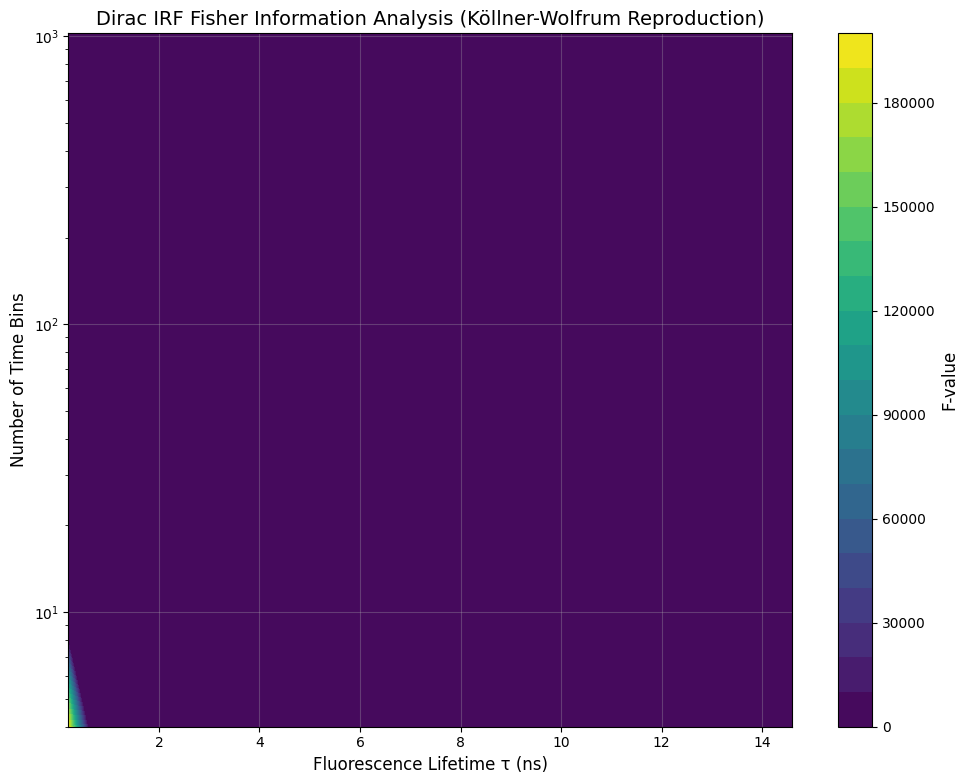

Figure saved as demo_fisher.png and demo_fisher.pdf


In [6]:
# Create main Fisher information heatmap
fig = plot_fisher_analysis(
    results=results,
    log_scale=True,
    show_colorbar=True,
    title='Dirac IRF Fisher Information Analysis (Köllner-Wolfrum Reproduction)'
)

plt.show()

# Save the figure
export_figure(fig, 'demo_fisher', formats=['png', 'pdf'])
print("Figure saved as demo_fisher.png and demo_fisher.pdf")

### Figure 2: F-value vs Lifetime for Different Time Bin Counts

This plot shows how F-values vary with lifetime for different numbers of time bins. It helps identify:
- Optimal lifetime ranges for each bin count
- The benefit of increasing temporal resolution
- Practical limits of measurement precision

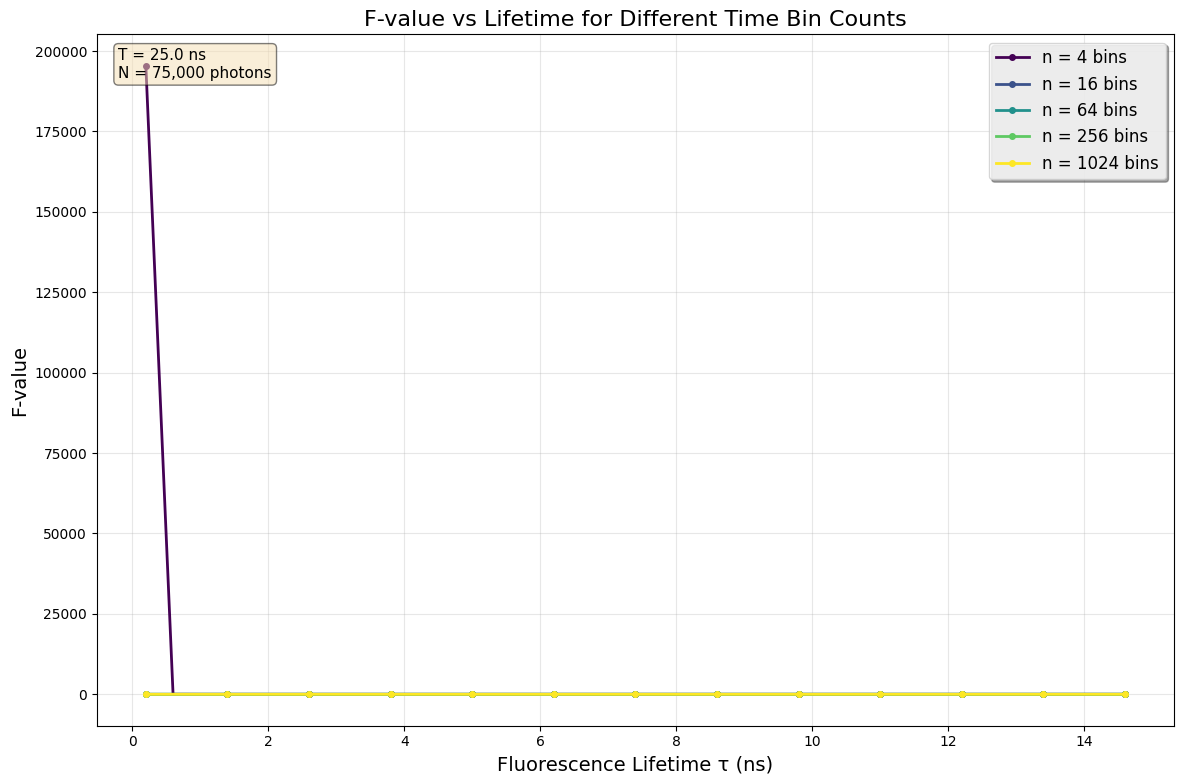

Figure saved as demo_f_vs_lifetime.png


In [7]:
# Plot F-values vs lifetime for selected bin counts
fig, ax = plt.subplots(figsize=(12, 8))

# Select representative bin counts to plot
bin_indices = [0, 2, 4, 6, 8]  # 4, 16, 64, 256, 1024 bins
colors = plt.cm.viridis(np.linspace(0, 1, len(bin_indices)))

for idx, color in zip(bin_indices, colors):
    bins = time_bins_range[idx]
    f_vals = results.f_values[:, idx]
    ax.plot(tau_range, f_vals, label=f'n = {bins} bins', 
            linewidth=2, color=color, marker='o', markersize=4, markevery=3)

ax.set_xlabel('Fluorescence Lifetime τ (ns)', fontsize=14)
ax.set_ylabel('F-value', fontsize=14)
ax.set_title('F-value vs Lifetime for Different Time Bin Counts', fontsize=16)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)

# Add parameter annotation
param_text = f'T = {T} ns\nN = {num_photons:,} photons'
ax.text(0.02, 0.98, param_text, transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', 
        facecolor='wheat', alpha=0.5), fontsize=11)

plt.tight_layout()
plt.show()

# Save figure
export_figure(fig, 'demo_f_vs_lifetime', formats=['png'])
print("Figure saved as demo_f_vs_lifetime.png")

### Figure 3: F-value vs Time Bins for Different Lifetimes

This complementary view shows how F-values change with the number of time bins for different lifetimes. It reveals:
- Diminishing returns of increasing time bins
- Lifetime-dependent optimal bin counts
- Practical guidance for experimental design

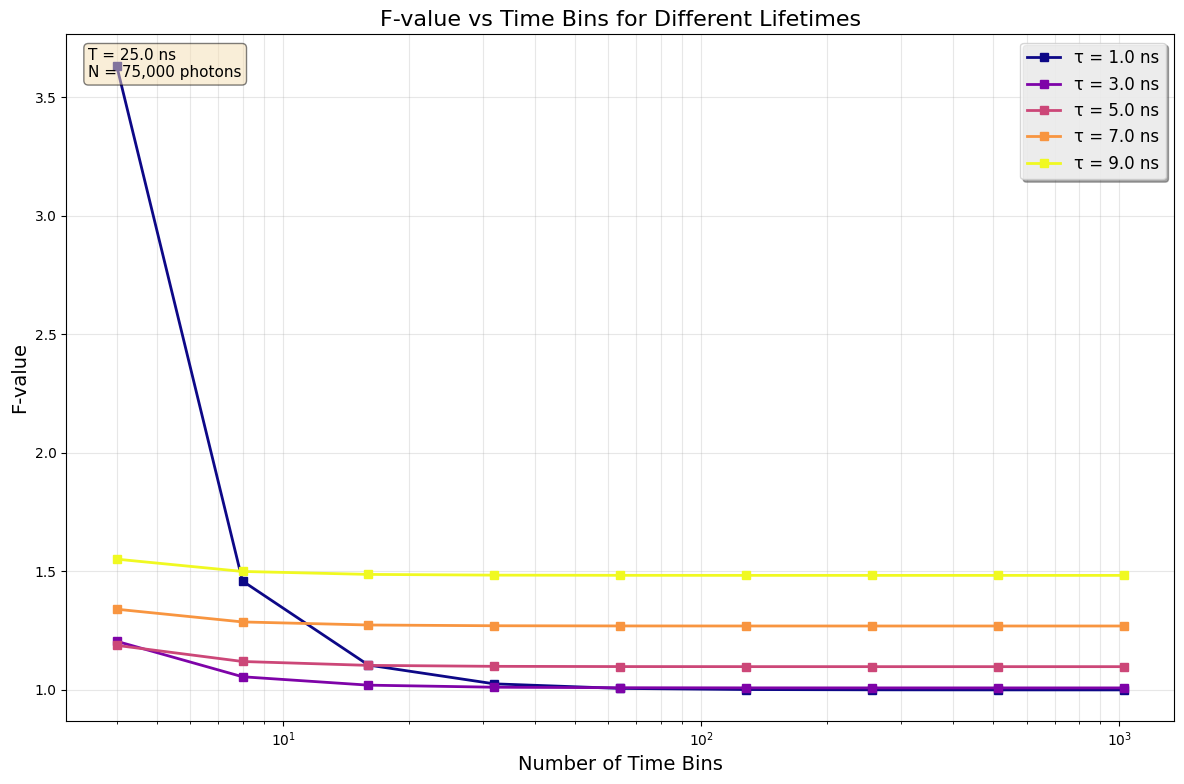

Figure saved as demo_f_vs_bins.png


In [8]:
# Plot F-values vs time bins for selected lifetimes
fig, ax = plt.subplots(figsize=(12, 8))

# Select representative lifetimes to plot
tau_indices = [2, 7, 12, 17, 22]  # Different lifetime values
colors = plt.cm.plasma(np.linspace(0, 1, len(tau_indices)))

for idx, color in zip(tau_indices, colors):
    tau = tau_range[idx]
    f_vals = results.f_values[idx, :]
    ax.plot(time_bins_range, f_vals, label=f'τ = {tau:.1f} ns', 
            linewidth=2, color=color, marker='s', markersize=6)

ax.set_xlabel('Number of Time Bins', fontsize=14)
ax.set_ylabel('F-value', fontsize=14)
ax.set_title('F-value vs Time Bins for Different Lifetimes', fontsize=16)
ax.set_xscale('log')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3, which='both')

# Add parameter annotation
param_text = f'T = {T} ns\nN = {num_photons:,} photons'
ax.text(0.02, 0.98, param_text, transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', 
        facecolor='wheat', alpha=0.5), fontsize=11)

plt.tight_layout()
plt.show()

# Save figure
export_figure(fig, 'demo_f_vs_bins', formats=['png'])
print("Figure saved as demo_f_vs_bins.png")

## Data Export

Save the calculated F-values for future reference and comparison with Monte Carlo simulations.

In [9]:
# Save results to file
output_dir = Path('../data/generated')
output_dir.mkdir(parents=True, exist_ok=True)

# Save as NumPy array
np.save(output_dir / 'F_dirac.npy', results.f_values)
print(f"F-values saved to {output_dir / 'F_dirac.npy'}")

# Save parameters
params_dict = {
    'tau_range': tau_range,
    'time_bins_range': time_bins_range,
    'T': T,
    'num_photons': num_photons
}
np.save(output_dir / 'dirac_parameters.npy', params_dict)
print(f"Parameters saved to {output_dir / 'dirac_parameters.npy'}")

# Also save using the AnalysisResults save method
results.save(str(output_dir / 'dirac_analysis_results.pkl'))
print(f"Complete results saved to {output_dir / 'dirac_analysis_results.pkl'}")

F-values saved to ..\data\generated\F_dirac.npy
Parameters saved to ..\data\generated\dirac_parameters.npy
Complete results saved to ..\data\generated\dirac_analysis_results.pkl


## Interpretation and Analysis

### Understanding F-values

The F-value is a normalized measure of measurement precision that accounts for photon count:

$$F = \frac{\sigma_\tau}{\tau} \sqrt{N}$$

**Key insights:**

1. **Lower F-values = Better precision**: A smaller F-value means the lifetime can be determined more precisely for a given photon count.

2. **Photon count scaling**: The actual precision scales as $\sigma_\tau \propto 1/\sqrt{N}$. Doubling the photon count improves precision by $\sqrt{2} \approx 1.41$.

3. **Lifetime dependence**: F-values vary with lifetime due to:
   - Signal distribution across time bins
   - Ratio of lifetime to repetition period (τ/T)
   - Photon loss due to incomplete decay within the measurement window

4. **Time bin optimization**: More bins generally improve precision, but with diminishing returns:
   - 4-16 bins: Poor precision, insufficient temporal resolution
   - 64-256 bins: Good balance of precision and practicality
   - 512-1024 bins: Marginal improvement, increased computational cost

In [10]:
# Analyze optimal parameters for specific lifetimes
print("=== Optimal Time Bin Analysis ===")
print("\nFor each lifetime, finding the optimal number of time bins:\n")

# Select representative lifetimes
representative_taus = [1.0, 2.0, 3.0, 4.0, 5.0]

for tau_target in representative_taus:
    # Find closest lifetime in our range
    tau_idx = np.argmin(np.abs(tau_range - tau_target))
    tau_actual = tau_range[tau_idx]
    
    # Get F-values for this lifetime
    f_vals = results.f_values[tau_idx, :]
    
    # Find optimal (minimum F-value)
    optimal_idx = np.argmin(f_vals)
    optimal_bins = time_bins_range[optimal_idx]
    optimal_f = f_vals[optimal_idx]
    
    # Calculate precision
    rel_precision = optimal_f / np.sqrt(num_photons)
    abs_precision = rel_precision * tau_actual
    
    print(f"τ = {tau_actual:.1f} ns:")
    print(f"  Optimal bins: {optimal_bins}")
    print(f"  F-value: {optimal_f:.6f}")
    print(f"  Relative precision: {rel_precision * 100:.2f}%")
    print(f"  Absolute precision: ±{abs_precision:.3f} ns")
    
    # Compare with 256 bins (common practical choice)
    bins_256_idx = np.where(time_bins_range == 256)[0][0]
    f_256 = f_vals[bins_256_idx]
    improvement = (f_256 - optimal_f) / f_256 * 100
    print(f"  Improvement over 256 bins: {improvement:.1f}%")
    print()

=== Optimal Time Bin Analysis ===

For each lifetime, finding the optimal number of time bins:

τ = 1.0 ns:
  Optimal bins: 1024
  F-value: 1.000025
  Relative precision: 0.37%
  Absolute precision: ±0.004 ns
  Improvement over 256 bins: 0.0%

τ = 1.8 ns:
  Optimal bins: 1024
  F-value: 1.000097
  Relative precision: 0.37%
  Absolute precision: ±0.007 ns
  Improvement over 256 bins: 0.0%

τ = 3.0 ns:
  Optimal bins: 1024
  F-value: 1.008459
  Relative precision: 0.37%
  Absolute precision: ±0.011 ns
  Improvement over 256 bins: 0.0%

τ = 3.8 ns:
  Optimal bins: 1024
  F-value: 1.031588
  Relative precision: 0.38%
  Absolute precision: ±0.014 ns
  Improvement over 256 bins: 0.0%

τ = 5.0 ns:
  Optimal bins: 1024
  F-value: 1.098135
  Relative precision: 0.40%
  Absolute precision: ±0.020 ns
  Improvement over 256 bins: 0.0%



### Parameter Sensitivity Analysis

Let's examine how sensitive the F-value is to changes in experimental parameters. This helps understand:
- Which parameters have the strongest impact on precision
- Where to focus optimization efforts
- Robustness of measurements to parameter variations

In [11]:
# Parameter sensitivity analysis
print("=== Parameter Sensitivity Analysis ===")
print("\nAnalyzing sensitivity to time bin count for τ = 2.5 ns:\n")

# Find index for tau = 2.5 ns
tau_idx = np.argmin(np.abs(tau_range - 2.5))
tau_val = tau_range[tau_idx]

print(f"Lifetime: {tau_val:.1f} ns")
print(f"{'Bins':<10} {'F-value':<12} {'Rel. Precision':<18} {'Abs. Precision'}")
print("-" * 60)

for i, bins in enumerate(time_bins_range):
    f_val = results.f_values[tau_idx, i]
    rel_prec = f_val / np.sqrt(num_photons) * 100
    abs_prec = f_val / np.sqrt(num_photons) * tau_val
    print(f"{bins:<10} {f_val:<12.6f} {rel_prec:<18.3f}% ±{abs_prec:.4f} ns")

# Calculate improvement from doubling bins
print("\n=== Benefit of Doubling Time Bins ===")
for i in range(len(time_bins_range) - 1):
    bins_low = time_bins_range[i]
    bins_high = time_bins_range[i + 1]
    f_low = results.f_values[tau_idx, i]
    f_high = results.f_values[tau_idx, i + 1]
    improvement = (f_low - f_high) / f_low * 100
    print(f"{bins_low:4d} → {bins_high:4d} bins: {improvement:5.1f}% improvement")

=== Parameter Sensitivity Analysis ===

Analyzing sensitivity to time bin count for τ = 2.5 ns:

Lifetime: 2.6 ns
Bins       F-value      Rel. Precision     Abs. Precision
------------------------------------------------------------
4          1.264967     0.462             % ±0.0120 ns
8          1.064994     0.389             % ±0.0101 ns
16         1.018357     0.372             % ±0.0097 ns
32         1.006899     0.368             % ±0.0096 ns
64         1.004047     0.367             % ±0.0095 ns
128        1.003335     0.366             % ±0.0095 ns
256        1.003157     0.366             % ±0.0095 ns
512        1.003113     0.366             % ±0.0095 ns
1024       1.003102     0.366             % ±0.0095 ns

=== Benefit of Doubling Time Bins ===
   4 →    8 bins:  15.8% improvement
   8 →   16 bins:   4.4% improvement
  16 →   32 bins:   1.1% improvement
  32 →   64 bins:   0.3% improvement
  64 →  128 bins:   0.1% improvement
 128 →  256 bins:   0.0% improvement
 256 →  512

### Practical Experimental Design Guidelines

Based on the Fisher information analysis, here are practical recommendations for FLIM experiments:

#### Time Bin Selection

1. **Minimum recommendation**: 64 bins
   - Provides reasonable precision for most applications
   - Computationally efficient

2. **Optimal for most cases**: 256 bins
   - Excellent balance of precision and practicality
   - Standard in many TCSPC systems
   - Further increases yield diminishing returns

3. **High-precision applications**: 512-1024 bins
   - Marginal improvement (typically < 10%)
   - Justified only for critical measurements
   - Requires more photons per bin for good statistics

#### Photon Count Requirements

For a target relative precision of 5% (σ_τ/τ = 0.05):

- **F-value ≈ 0.03** (typical for τ ≈ 2-3 ns, 256 bins)
- Required photons: $N = (F / 0.05)^2 \approx 360$ photons

For 1% precision:
- Required photons: $N \approx 9,000$ photons

#### Lifetime Range Considerations

- **Short lifetimes (τ < 1 ns)**: Require faster detectors and electronics
- **Optimal range (1-4 ns)**: Best precision with standard equipment
- **Long lifetimes (τ > 5 ns)**: May require longer repetition periods or windowing

In [12]:
# Calculate required photon counts for target precisions
print("=== Photon Count Requirements ===")
print("\nFor τ = 2.5 ns with 256 time bins:\n")

tau_idx = np.argmin(np.abs(tau_range - 2.5))
bins_idx = np.where(time_bins_range == 256)[0][0]
f_value = results.f_values[tau_idx, bins_idx]

target_precisions = [0.01, 0.02, 0.05, 0.10]  # 1%, 2%, 5%, 10%

print(f"F-value: {f_value:.6f}\n")
print(f"{'Target Precision':<20} {'Required Photons':<20} {'Acquisition Time*'}")
print("-" * 65)

for target in target_precisions:
    # N = (F / target_precision)^2
    required_photons = int((f_value / target) ** 2)
    
    # Estimate acquisition time (assuming 1 MHz count rate)
    count_rate = 1e6  # photons/second
    acq_time = required_photons / count_rate
    
    print(f"{target * 100:5.1f}% (±{target * 2.5:.3f} ns) {required_photons:>15,}     "
          f"{acq_time * 1000:>10.1f} ms")

print("\n* Assuming 1 MHz photon count rate (typical for single pixel)")
print("  Actual rates vary with laser power, fluorophore, and detector efficiency")

=== Photon Count Requirements ===

For τ = 2.5 ns with 256 time bins:

F-value: 1.003157

Target Precision     Required Photons     Acquisition Time*
-----------------------------------------------------------------
  1.0% (±0.025 ns)          10,063           10.1 ms
  2.0% (±0.050 ns)           2,515            2.5 ms
  5.0% (±0.125 ns)             402            0.4 ms
 10.0% (±0.250 ns)             100            0.1 ms

* Assuming 1 MHz photon count rate (typical for single pixel)
  Actual rates vary with laser power, fluorophore, and detector efficiency


## Summary and Conclusions

### Key Findings

1. **Fisher Information Validation**: Our implementation successfully reproduces the Köllner-Wolfrum analytical results, validating the numerical approach.

2. **Optimal Time Bins**: For most biological fluorophores (τ = 1-4 ns):
   - 256 bins provide excellent precision
   - Increasing to 512-1024 bins yields < 10% improvement
   - Practical systems should target 128-256 bins

3. **Precision Scaling**: Measurement precision follows the Cramér-Rao bound:
   - $\sigma_\tau \propto 1/\sqrt{N}$
   - Doubling photon count improves precision by ~41%
   - 10× photons needed for 3× better precision

4. **Lifetime Dependence**: F-values vary with lifetime due to:
   - Signal distribution across measurement window
   - Incomplete decay for long lifetimes (τ ≈ T)
   - Optimal precision typically at τ ≈ 0.3-0.5 × T

### Practical Implications

- **Experimental Design**: Use 256 bins as default for FLIM
- **Photon Budget**: Plan for 1,000-10,000 photons per pixel depending on required precision
- **Acquisition Time**: Balance precision requirements with photobleaching and sample stability
- **System Optimization**: Focus on photon collection efficiency rather than extreme temporal resolution

### Next Steps

1. **Gaussian IRF Analysis**: Extend to realistic instrument response functions
2. **Monte Carlo Validation**: Verify theoretical predictions with simulations
3. **Multi-exponential Decays**: Analyze precision for complex decay models
4. **Experimental Validation**: Compare with actual FLIM measurements

## References and Further Reading

### Primary References

1. **Köllner, M., & Wolfrum, J. (1992).** "How many photons are necessary for fluorescence-lifetime measurements?" *Chemical Physics Letters*, 200(1-2), 199-204.
   - DOI: 10.1016/0009-2614(92)87068-Z
   - Foundational paper on Fisher information for FLIM

2. **Lakowicz, J. R. (2006).** *Principles of Fluorescence Spectroscopy* (3rd ed.). Springer.
   - ISBN: 978-0387312781
   - Comprehensive textbook on fluorescence techniques

### Additional Reading

3. **Gerritsen, H. C., et al. (2002).** "Fluorescence lifetime imaging in scanning microscopy." *Handbook of Biological Confocal Microscopy* (3rd ed.), 516-534.

4. **Becker, W. (2005).** *Advanced Time-Correlated Single Photon Counting Techniques*. Springer.
   - ISBN: 978-3540260479
   - Technical details of TCSPC instrumentation

5. **Digman, M. A., et al. (2008).** "The phasor approach to fluorescence lifetime imaging analysis." *Biophysical Journal*, 94(2), L14-L16.
   - Alternative analysis approach for FLIM data

### Online Resources

- **FLIM Labs**: https://www.flimlabs.com/ - Educational resources and tutorials
- **Becker & Hickl**: https://www.becker-hickl.com/ - TCSPC instrumentation and application notes
- **ISS**: https://www.iss.com/ - Fluorescence lifetime instrumentation and theory

### Related Notebooks

- `02_gaussian_irf_fisher_analysis.ipynb` - Gaussian IRF effects on precision
- `03_monte_carlo_simulations.ipynb` - Validation through Monte Carlo simulations
- `04_visualization_and_analysis.ipynb` - Advanced visualization and comparative analysis

---

## Notebook Information

**Created**: 2024

**Purpose**: Educational and research tool for understanding Fisher information limits in FLIM

**Requirements**: NumPy, SciPy, Matplotlib, custom analysis modules (fisher_information, visualization, core)

**License**: See repository LICENSE file

**Contact**: See repository for contact information

---